In [1]:
import torch

import torch.nn as nn
import os
import shutil
import itertools
import random

from chofer_torchex.utils.data.collate import dict_sample_target_iter_concat
from chofer_torchex.utils.functional import collection_cascade, cuda_cascade
from jmlr_2018_code.datasets import Mpeg7
from jmlr_2018_code.utils import *
from chofer_torchex.nn.slayer import SLayerExponential, SLayerRational, LogStretchedBirthLifeTimeCoordinateTransform, prepare_batch
from sklearn.model_selection import ShuffleSplit
from collections import Counter, defaultdict
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.autograd import Variable

%matplotlib notebook
%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES'] = str(0)


class train_env:
    nu = 0.01
    n_epochs = 400
    lr_initial = 0.01
    lr_epoch_step = 100
    batch_size = 100
    train_size = 0.9
    

coordinate_transform = LogStretchedBirthLifeTimeCoordinateTransform(nu=train_env.nu)
            

# used_directions = ['dim_0_dir_{}'.format(i) for i in [0, 4, 8, 12, 18, 22, 26, 30]]
used_directions = ['dim_0_dir_{}'.format(i) for i in range(0, 32,2)]
mpeg7_data_set = Mpeg7(root_dir='./data')
mpeg7_data_set.sample_transforms = [
                                    lambda x: {k: x[k] for k in used_directions}, 
                                    numpy_to_torch_cascade,
                                    lambda x: collection_cascade(x, 
                                                                 lambda x: isinstance(x, torch._TensorBase), 
                                                                 lambda x: coordinate_transform(x))
                                   ]

Found data!


In [2]:
class PDDictCollate:   
    def __init__(self, nu, cuda=True, rotation_augmentation=False):
        self.cuda = cuda
        self.rotation_augmentation = rotation_augmentation
        
    def __call__(self, sample_target_iter):
        
        augmented_samples = []
        if self.rotation_augmentation:
            samples, targets = [], []
            for x, y in sample_target_iter:                
                i = random.randint(0, len(used_directions)-1)
                shifted_keys = used_directions[i:] + used_directions[:i]                
                
                samples.append({k: x[ki] for k, ki in zip(used_directions, shifted_keys)})
                targets.append(y)
                
            sample_target_iter = zip(samples, targets)

        x, y = dict_sample_target_iter_concat(sample_target_iter)                                            
                                              
        for k in x.keys():
            batch_view = x[k]
            x[k] = prepare_batch(batch_view, 2)                  

        y = torch.LongTensor(y)    

        if self.cuda:
            # Shifting the necessary parts of the prepared batch to the cuda
            x = {k: collection_cascade(v,
                                       lambda x: isinstance(x, tuple),
                                       lambda x: (x[0].cuda(), x[1].cuda(), x[2], x[3]))
                 for k, v in x.items()}

            y = y.cuda()

        return x, y
                                              
 
class UnitSGD(torch.optim.SGD):
    def step(self, closure=None):
        
        loss = None
        if closure is not None:
            loss = closure()
        
        norm = 0
        for group in self.param_groups:
                for p in group['params']:
                    norm += float(p.grad.norm(1))
                    
        for group in self.param_groups:
            for p in group['params']:
                p.grad.data = p.grad.data/norm                 
        
        super(UnitSGD, self).step()  
        
        return loss
                                              
    
collate_fn_train = PDDictCollate(train_env.nu, cuda=True)
collate_fn_test = PDDictCollate(train_env.nu, cuda=True)

In [3]:
class ModuleDict(nn.Module):
    def __init__(self):
        super().__init__()
        
    def __setitem__(self, key, item):
        setattr(self, key, item)
        
    def __getitem__(self, key):
        return getattr(self, key)
    

def Slayer(n_elements):
    return SLayerRational(n_elements=n_elements, 
                          point_dimension=2, 
                          sharpness_init=50, 
                          exponent_init=2, 
                          share_sharpness=False,
                          share_exponent=True,
                          pointwise_activation_threshold=None,
                          freeze_exponent=True
                          )

#     return SLayerExponential(n_elements=n_elements, point_dimension=2)


def LinearCell(n_in, n_out):
    m = nn.Sequential(nn.Linear(n_in, n_out), 
                      nn.BatchNorm1d(n_out), 
                      nn.ReLU())
    m.out_features = m[0].out_features
    return m


class Mpeg7_model(nn.Module):
    def __init__(self):
        super().__init__()   
        self.n_elements = 150
        
#         self.lstm_in_dim = self.n_elements
#         self.lstm_hidden_dim = self.n_elements
#         self.lstm_n_hidden_layers = 2
        self.batch_size = train_env.batch_size
        
        self.slayers = ModuleDict()
#         self.slayers_2_lstm_linears = ModuleDict()
#         self.slayer_drop_outs = ModuleDict()
        for k in used_directions:
            s = Slayer(self.n_elements)
            self.slayers[k] = s
            
#             self.slayer_drop_outs[k] = nn.Dropout(0.2)
            
#             l = nn.Linear(s.n_elements, self.lstm_in_dim)
#             self.slayers_2_lstm_linears[k] = l
            
        self.recurrent = nn.LSTM(self.n_elements, self.n_elements)
        
        n_1 =1000
        self.cls = nn.Sequential(
                                 nn.Dropout(0.4),
                                 nn.BatchNorm1d(self.n_elements),
                                 LinearCell(self.n_elements, n_1),
                                 nn.Dropout(0.3),
                                 LinearCell(n_1, int(n_1/2)),
                                 nn.Dropout(0.1),
                                 LinearCell(int(n_1/2), 70),
                                )
        
    def forward(self, input):
        x = []
        for k in used_directions:
            
            xx = self.slayers[k](input[k])
#             xx = self.slayer_drop_outs[k](xx)
#             xx = self.slayers_2_lstm_linears[k](xx)
            x.append(xx)

        x = torch.stack(x, dim=0)  
#         x = torch.cat([x]*10, dim=0)
        
        x = self.recurrent(x)
        
        x, _ = x[-1]
        x = x.squeeze()
        
        x = self.cls(x)        
               
        return x
    
    def parameters_split(self):
        return {'non_linear': self.slayers.parameters(),
                'linear': itertools.chain(self.cls.parameters(), self.recurrent.parameters())}
    
    def center_init(self, sample_target_iter):
        centers = k_means_center_init(sample_target_iter, self.n_elements)
        
        for k, v in centers.items():
            self.slayers._modules[k].centers.data = v
            
            

In [11]:
train_sampler, test_sampler = get_train_test_sampler(mpeg7_data_set, train_env.train_size, stratified=True)

dl_train = DataLoader(mpeg7_data_set,
                      batch_size=train_env.batch_size, 
                      collate_fn=collate_fn_train,
                      sampler=train_sampler)

dl_test = DataLoader(mpeg7_data_set,
                     batch_size=train_env.batch_size, 
                     collate_fn=collate_fn_test, 
                     sampler=test_sampler)

model = Mpeg7_model()
model.center_init([mpeg7_data_set[i] for i in train_sampler])
model.cuda()

stats = defaultdict(list)
opt = torch.optim.SGD(model.parameters(), lr=train_env.lr_initial, momentum=0.9)

for i_epoch in range(1, train_env.n_epochs+1):      
    
    model.train()
        
    epoch_loss = 0    
    
    if i_epoch % train_env.lr_epoch_step == 0:
        adapt_lr(opt, lambda lr: lr*0.5)
        
#     if (i_epoch % train_env.lr_epoch_step ) <= train_env.lr_epoch_step/2:        
#         opt=torch.optim.SGD(model.parameters_split()['linear'], lr=lr, momentum=0.9)
#     else:
#         opt=torch.optim.SGD(model.parameters_split()['non_linear'], lr=lr, momentum=0.9)
    
    for i_batch, (x, y) in enumerate(dl_train, 1):              
        
        y = torch.autograd.Variable(y)
        
        def closure():
            opt.zero_grad()
            y_hat = model(x)            
            loss = nn.functional.cross_entropy(y_hat, y)   
            loss.backward()
            return loss

        loss = opt.step(closure)
        
        epoch_loss += float(loss)
        stats['loss_by_batch'].append(float(loss))
        stats['centers'].append(model.slayers['dim_0_dir_0'].centers.data.cpu().numpy())
#         stats['centers_grad'].append(model.dim_0.centers.grad.data.cpu().numpy())
#         stats['exponent'].append(model.dim_0.exponent.data.cpu().numpy())
        
        print("Epoch {}/{}, Batch {}/{}".format(i_epoch, train_env.n_epochs, i_batch, len(dl_train)), end="       \r")
  
    stats['train_loss_by_epoch'].append(epoch_loss/len(dl_train))
        
    print("\n\r testing...")
    model.eval()    
    true_samples = 0
    seen_samples = 0
    epoch_test_loss = 0
    for i_batch, (x, y) in enumerate(dl_test):

        y_hat = model(x)
        epoch_test_loss += float(nn.functional.cross_entropy(y_hat, torch.autograd.Variable(y.cuda())).data)

        y_hat = y_hat.max(dim=1)[1].data.long()

        true_samples += (y_hat == y).sum()
        seen_samples += y.size(0)  
     
    stats['test_accuracy'].append(true_samples/seen_samples)
    stats['test_loss_by_epoch'].append(epoch_test_loss/len(dl_test))
    print(true_samples/seen_samples)

Generated training and testing split:
Train: Counter({60: 18, 30: 18, 7: 18, 45: 18, 47: 18, 22: 18, 14: 18, 53: 18, 32: 18, 62: 18, 37: 18, 49: 18, 1: 18, 68: 18, 29: 18, 67: 18, 0: 18, 11: 18, 69: 18, 6: 18, 41: 18, 12: 18, 66: 18, 23: 18, 27: 18, 61: 18, 40: 18, 48: 18, 51: 18, 5: 18, 18: 18, 50: 18, 2: 18, 65: 18, 57: 18, 31: 18, 4: 18, 63: 18, 26: 18, 19: 18, 56: 18, 21: 18, 17: 18, 58: 18, 44: 18, 39: 18, 35: 18, 9: 18, 28: 18, 33: 18, 15: 18, 25: 18, 38: 18, 59: 18, 34: 18, 55: 18, 54: 18, 42: 18, 52: 18, 8: 18, 36: 18, 64: 18, 20: 18, 43: 18, 46: 18, 24: 18, 10: 18, 16: 18, 13: 18, 3: 18})
Test: Counter({48: 2, 25: 2, 2: 2, 60: 2, 57: 2, 42: 2, 63: 2, 44: 2, 68: 2, 69: 2, 67: 2, 17: 2, 33: 2, 38: 2, 4: 2, 12: 2, 51: 2, 66: 2, 28: 2, 10: 2, 26: 2, 65: 2, 41: 2, 46: 2, 34: 2, 11: 2, 56: 2, 27: 2, 36: 2, 23: 2, 15: 2, 53: 2, 16: 2, 58: 2, 62: 2, 29: 2, 40: 2, 54: 2, 39: 2, 9: 2, 0: 2, 55: 2, 14: 2, 19: 2, 13: 2, 37: 2, 7: 2, 1: 2, 45: 2, 50: 2, 31: 2, 22: 2, 3: 2, 24: 2, 18: 2, 64

Epoch 115/400, Batch 13/13       
 testing...
0.8
Epoch 116/400, Batch 13/13       
 testing...
0.8
Epoch 117/400, Batch 13/13       
 testing...
0.8142857142857143
Epoch 118/400, Batch 13/13       
 testing...
0.7928571428571428
Epoch 119/400, Batch 13/13       
 testing...
0.8285714285714286
Epoch 120/400, Batch 13/13       
 testing...
0.7857142857142857
Epoch 121/400, Batch 13/13       
 testing...
0.7857142857142857
Epoch 122/400, Batch 13/13       
 testing...
0.8
Epoch 123/400, Batch 13/13       
 testing...
0.8357142857142857
Epoch 124/400, Batch 13/13       
 testing...
0.7714285714285715
Epoch 125/400, Batch 13/13              
 testing...
0.8571428571428571
Epoch 126/400, Batch 13/13       
 testing...
0.8214285714285714
Epoch 127/400, Batch 13/13       
 testing...
0.8214285714285714
Epoch 128/400, Batch 13/13       
 testing...
0.8428571428571429
Epoch 129/400, Batch 13/13       
 testing...
0.85
Epoch 130/400, Batch 13/13       
 testing...
0.7857142857142857
Epoch 131/40

Epoch 243/400, Batch 13/13       
 testing...
0.8785714285714286
Epoch 244/400, Batch 13/13       
 testing...
0.8785714285714286
Epoch 245/400, Batch 13/13       
 testing...
0.8928571428571429
Epoch 246/400, Batch 13/13       
 testing...
0.8857142857142857
Epoch 247/400, Batch 13/13       
 testing...
0.9071428571428571
Epoch 248/400, Batch 13/13       
 testing...
0.9071428571428571
Epoch 249/400, Batch 13/13       
 testing...
0.9
Epoch 250/400, Batch 13/13       
 testing...
0.9142857142857143
Epoch 251/400, Batch 13/13       
 testing...
0.9071428571428571
Epoch 252/400, Batch 13/13       
 testing...
0.9214285714285714
Epoch 253/400, Batch 13/13       
 testing...
0.9142857142857143
Epoch 254/400, Batch 13/13       
 testing...
0.9214285714285714
Epoch 255/400, Batch 13/13       
 testing...
0.9142857142857143
Epoch 256/400, Batch 13/13       
 testing...
0.9142857142857143
Epoch 257/400, Batch 13/13       
 testing...
0.9071428571428571
Epoch 258/400, Batch 13/13       
 testi

Epoch 378/400, Batch 13/13       
 testing...
0.8928571428571429
Epoch 379/400, Batch 13/13       
 testing...
0.9
Epoch 380/400, Batch 13/13       
 testing...
0.9
Epoch 381/400, Batch 13/13       
 testing...
0.9
Epoch 382/400, Batch 13/13       
 testing...
0.9
Epoch 383/400, Batch 13/13       
 testing...
0.8928571428571429
Epoch 384/400, Batch 13/13       
 testing...
0.9071428571428571
Epoch 385/400, Batch 13/13       
 testing...
0.9
Epoch 386/400, Batch 13/13       
 testing...
0.9
Epoch 387/400, Batch 13/13       
 testing...
0.9
Epoch 388/400, Batch 13/13             
 testing...
0.9071428571428571
Epoch 389/400, Batch 13/13       
 testing...
0.9
Epoch 390/400, Batch 13/13       
 testing...
0.9071428571428571
Epoch 391/400, Batch 13/13       
 testing...
0.9
Epoch 392/400, Batch 13/13       
 testing...
0.9
Epoch 393/400, Batch 13/13       
 testing...
0.9071428571428571
Epoch 394/400, Batch 13/13       
 testing...
0.9071428571428571
Epoch 395/400, Batch 13/13       
 test

<IPython.core.display.Javascript object>


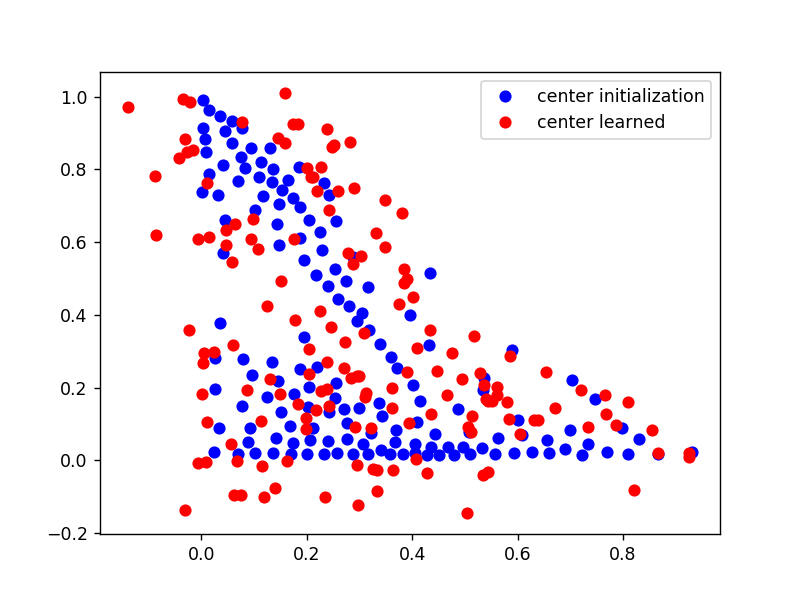

<IPython.core.display.Javascript object>


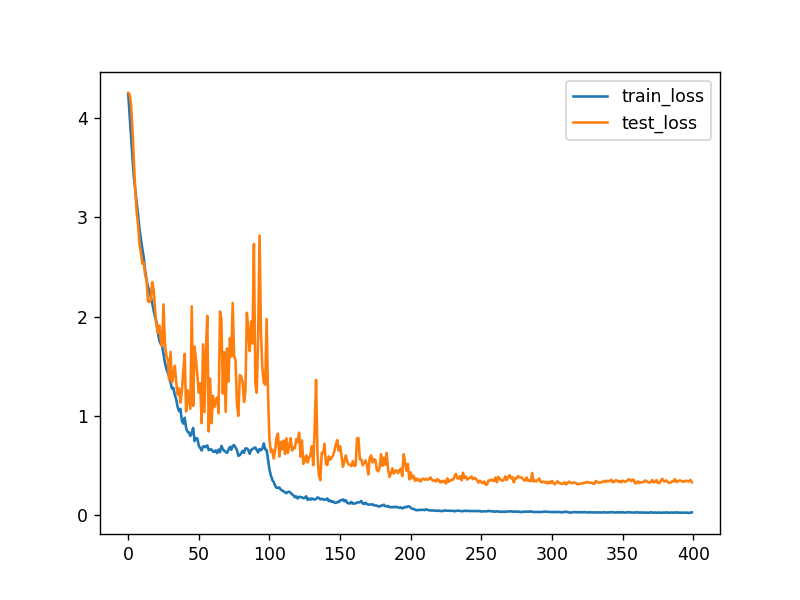

In [12]:
plt.figure()

if 'centers' in stats:
    c_start = stats['centers'][0]
    c_end = stats['centers'][-1]

    plt.plot(c_start[:,0], c_start[:, 1], 'bo', label='center initialization')
    plt.plot(c_end[:,0], c_end[:, 1], 'ro', label='center learned')

    all_centers = numpy.stack(stats['centers'], axis=0)
    for i in range(all_centers.shape[1]):
        points = all_centers[:,i, :]
        

    plt.legend()
    
plt.figure()
plt.plot(stats['train_loss_by_epoch'], label='train_loss')
plt.plot(stats['test_loss_by_epoch'], label='test_loss')


plt.legend()
plt.show()